In [1]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# clone darknet repo
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15442, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 15442 (delta 1), reused 14 (delta 1), pack-reused 15424
Receiving objects: 100% (15442/15442), 14.07 MiB | 21.15 MiB/s, done.
Resolving deltas: 100% (10366/10366), done.


In [3]:
# change makefile to have GPU, OPENCV and LIBSO enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile

/content/darknet


In [4]:
# make darknet (builds darknet so that we can then use the darknet.py file and have its dependencies)
!make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -fPIC -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1147:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old ==

In [5]:
# get bthe scaled yolov4 weights file that is pre-trained to detect 80 classes (objects) from shared google drive
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://drive.google.com/uc?export=download&id=1WVDdHbHZnBZJZI6YYc9qyhbh_D4BbaBg' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1WVDdHbHZnBZJZI6YYc9qyhbh_D4BbaBg" -O yolov4-csp.weights && rm -rf /tmp/cookies.txt

--2022-07-06 18:44:21--  https://docs.google.com/uc?export=download&confirm=t&id=1WVDdHbHZnBZJZI6YYc9qyhbh_D4BbaBg
Resolving docs.google.com (docs.google.com)... 108.177.121.139, 108.177.121.113, 108.177.121.101, ...
Connecting to docs.google.com (docs.google.com)|108.177.121.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0o-2c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/i284het6kthnedd2ceic8caqvlan744o/1657133025000/12443865463207573116/*/1WVDdHbHZnBZJZI6YYc9qyhbh_D4BbaBg?e=download&uuid=b874f616-075a-4d8a-b800-473cadf2273a [following]
--2022-07-06 18:44:21--  https://doc-0o-2c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/i284het6kthnedd2ceic8caqvlan744o/1657133025000/12443865463207573116/*/1WVDdHbHZnBZJZI6YYc9qyhbh_D4BbaBg?e=download&uuid=b874f616-075a-4d8a-b800-473cadf2273a
Resolving doc-0o-2c-docs.googleusercontent.com (doc-0o-2c-docs.googleusercontent.com)... 74.125.129.1

In [6]:
# import darknet functions to perform object detections
from darknet import *
# load in our YOLOv4 architecture network
network, class_names, class_colors = load_network("cfg/yolov4-csp.cfg", "cfg/coco.data", "yolov4-csp.weights")
width = network_width(network)
height = network_height(network)

# darknet helper function to run detection on image
def darknet_helper(img, width, height):
  darknet_image = make_image(width, height, 3)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img_resized = cv2.resize(img_rgb, (width, height),
                              interpolation=cv2.INTER_LINEAR)

  # get image ratios to convert bounding boxes to proper size
  img_height, img_width, _ = img.shape
  width_ratio = img_width/width
  height_ratio = img_height/height

  # run model on darknet style image to get detections
  copy_image_from_bytes(darknet_image, img_resized.tobytes())
  detections = detect_image(network, class_names, darknet_image)
  free_image(darknet_image)
  return detections, width_ratio, height_ratio

In [11]:
url = input()


https://storage.googleapis.com/kaggle-media/competitions/Airbus/ships.jpg


In [12]:
from PIL import Image
import requests
image = Image.open(requests.get(url,stream=True).raw).resize((768,576))
print(image.size)
image.save('image.jpg')

(768, 576)


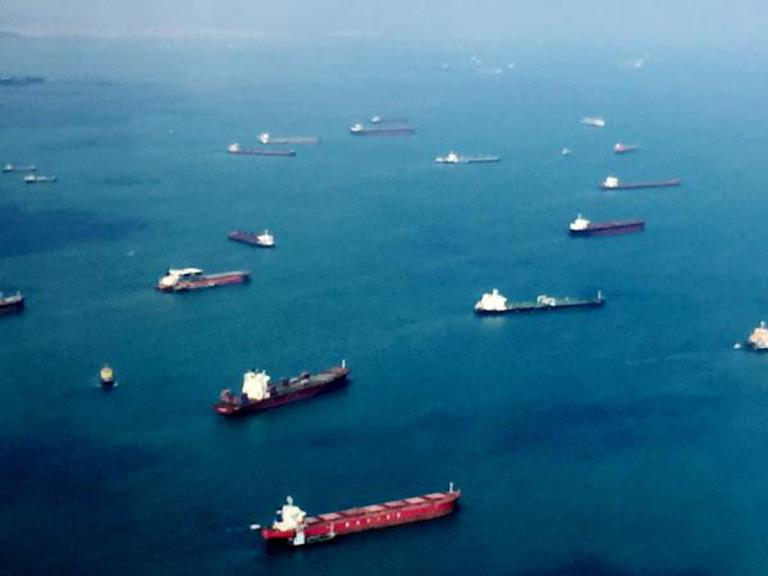

In [13]:
image = cv2.imread('image.jpg')
cv2_imshow(image)

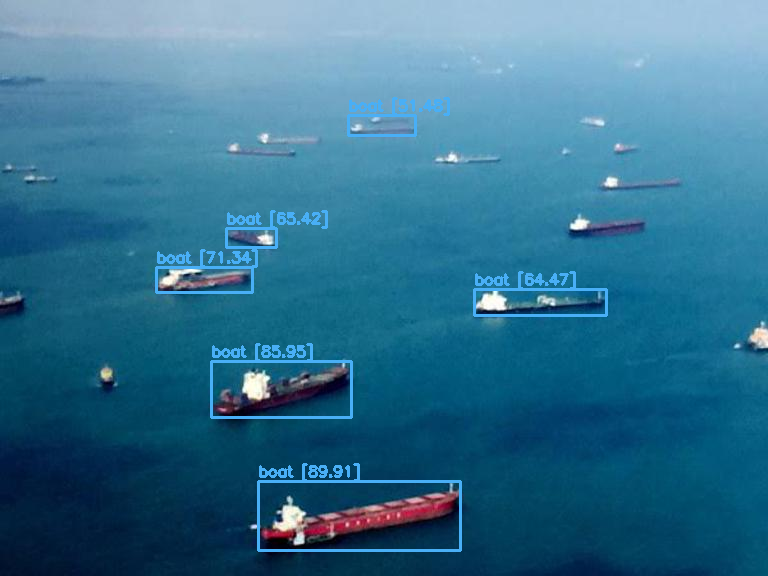

In [14]:
# run test on person.jpg image that comes with repository
# image = cv2.imread("data/dog.jpg")
detections, width_ratio, height_ratio = darknet_helper(image, width, height)

for label, confidence, bbox in detections:
  left, top, right, bottom = bbox2points(bbox)
  left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
  cv2.rectangle(image, (left, top), (right, bottom), class_colors[label], 2)
  cv2.putText(image, "{} [{:.2f}]".format(label, float(confidence)),
                    (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    class_colors[label], 2)
cv2_imshow(image)